In [1]:
from transformers import AutoModel, AutoTokenizer
import torch
import torch.nn as nn
import csv
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import sys
import random
import pandas as pd
from rerank_score_cands_new import load_cands
import numpy as np
from comet import download_model, load_from_checkpoint
import pickle

csv.field_size_limit(sys.maxsize)

2022-09-24 04:06:04.521878: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-24 04:06:04.521897: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


131072

In [2]:
# Encoder-Decoder Model Embedding, Add a Weighted Layer at the end that leads to regression
class XLMCometRegressor(nn.Module):
    
    def __init__(self, drop_rate=0.2):
        # TODO should we be freezing layers?
        super().__init__()
        
        self.xlmroberta = AutoModel.from_pretrained('xlm-roberta-base')
        # Num labels 1 should just indicate regression (?)
        self.regressor = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(self.xlmroberta.config.hidden_size, 1))
        self.to(device)
        
    def forward(self, input_ids, attention_masks):
        # don't finetune xlmroberta model
        with torch.no_grad():
            outputs = self.xlmroberta(input_ids, attention_mask=attention_masks, encoder_attention_mask=attention_masks)
        class_label_output = outputs[1]
        outputs = self.regressor(class_label_output)
        return outputs
    
model = XLMCometRegressor(drop_rate=0.2)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
model.load_state_dict(torch.load("./torchsaved/comestim8.pt"))

<All keys matched successfully>

In [4]:
 ### ### Older code, TODO clean up this notebook ### ###
def save_cometqe_data(md, xd, yd):
    # save data into a pickle file
    with open('processeddata/commasks.pkl', 'wb') as f:
        pickle.dump(md, f)

    with open('processeddata/cominps.pkl', 'wb') as f:
        pickle.dump(xd, f)

    with open('processeddata/comlabels.pkl', 'wb') as f:
        pickle.dump(yd, f)

def load_cometqe_data():
    with open('processeddata/commasks.pkl', 'rb') as f:
        masks = pickle.load(f)

    with open('processeddata/cominps.pkl', 'rb') as f:
        xinps = pickle.load(f)

    with open('processeddata/comlabels.pkl', 'rb') as f:
        yinps = pickle.load(f)
    return masks, xinps, yinps

mdata, xdata, ydata = load_cometqe_data()

In [8]:
xdata = [torch.tensor(x) for x in xdata]

In [11]:
cut = int(len(xdata)*.9)
xtrain, ytrain, mtrain = xdata[:cut], ydata[:cut], mdata[:cut]
xtest, ytest, mtest = xdata[cut:], ydata[cut:], mdata[cut:]

In [12]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

class RegressionDataset(Dataset):
    def __init__(self, sentences, labels, masks):
        assert len(sentences) == len(labels)
        self.sentences = sentences
        self.labels = labels
        self.masks = masks

    def __getitem__(self, i):
        return self.sentences[i], self.labels[i], self.masks[i]

    def __len__(self):
        return len(self.sentences)

def collate_custom(datafull):
    #print(len(datafull[0]))
    data = [torch.tensor(d[0]) for d in datafull]
    masdata=  [d[2] for d in datafull]
    labels = [d[1] for d in datafull]
    max_len = max([x.squeeze().numel() for x in data])
    data = [torch.nn.functional.pad(x, pad=(0, max_len - x.numel()), mode='constant', value=0) for x in data]
    data = torch.stack(data).to(device)
    masdata = [torch.nn.functional.pad(x, pad=(0, max_len - x[0].numel(), 0, max_len - x[0].numel()), mode='constant', value=0) for x in masdata]
    masdata = torch.stack(masdata).to(device)
    return data, torch.tensor(labels).to(device), masdata

testloader = DataLoader(RegressionDataset(xtest, ytest, mtest), batch_size=32, shuffle=False, collate_fn=collate_custom)
trainloader = DataLoader(RegressionDataset(xtrain, ytrain, mtrain), batch_size=32, shuffle=False, collate_fn=collate_custom)

In [20]:
loss_function = nn.MSELoss()
def evaluate(model, loss_function, test_dataloader, device):
    model.eval()
    test_loss, test_r2 = [], []
    pdistr = []
    for batch in test_dataloader:
        batch_inputs, batch_labels, batch_masks = \
                                 tuple(b.to(device) for b in batch)
        with torch.no_grad():
            outputs = model(batch_inputs, batch_masks)
        print(outputs.squeeze())
        print(batch_labels.squeeze())
        pdistr.extend(outputs)
        loss = loss_function(outputs.squeeze(), 
                             batch_labels.squeeze())
        test_loss.append(loss.item())
        #r2 = r2_score(outputs, batch_labels)
        #test_r2.append(r2.item())
    return test_loss, outputs

In [21]:
distr, outpreds = evaluate(model, loss_function, testloader, device)

/tmp/ipykernel_3426236/2613059981.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = [torch.tensor(d[0]) for d in datafull]


tensor([0.1079, 0.1079, 0.1083, 0.1081, 0.1085, 0.1086, 0.1086, 0.1086, 0.1079,
        0.1081, 0.1085, 0.1086, 0.1085, 0.1086, 0.1086, 0.1086, 0.1086, 0.1086,
        0.1086, 0.1084, 0.1084, 0.1086, 0.1086, 0.1086, 0.1086, 0.1087, 0.1080,
        0.1086, 0.1084, 0.1086, 0.1086, 0.1086], device='cuda:0')
tensor([ 1.2227,  0.9105,  0.6955,  0.5184,  1.0176,  0.8584, -0.3095,  0.5596,
         1.1021,  0.6812, -1.1900,  0.5573, -0.0515,  0.3817, -1.5592,  0.6363,
         0.6196,  0.9293, -1.2511,  0.9856,  0.9391,  0.6022, -1.4378, -0.9727,
         0.7300, -1.5616,  0.2582, -1.1921, -0.0815,  0.2851,  0.8453,  0.9949],
       device='cuda:0')
tensor([0.1086, 0.1086, 0.1080, 0.1085, 0.1086, 0.1086, 0.1085, 0.1086, 0.1087,
        0.1086, 0.1086, 0.1086, 0.1085, 0.1086, 0.1086, 0.1081, 0.1087, 0.1087,
        0.1085, 0.1075, 0.1086, 0.1073, 0.1077, 0.1086, 0.1085, 0.1086, 0.1083,
        0.1082, 0.1083, 0.1086, 0.1087, 0.1084], device='cuda:0')
tensor([ 0.7350, -1.4246,  0.8351,  0.7925,


KeyboardInterrupt



(array([ 13.,  47., 119., 112.,  97.,  66.,  29.,  14.,   2.,   1.]),
 array([0.51490718, 0.58987415, 0.66484113, 0.7398081 , 0.81477507,
        0.88974205, 0.96470902, 1.03967599, 1.11464297, 1.18960994,
        1.26457691]),
 <BarContainer object of 10 artists>)

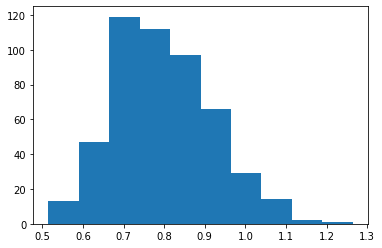

In [19]:
import matplotlib.pyplot as plt
plt.hist(distr)